In [5]:
%matplotlib inline

In [6]:
#Importing Packages
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from skimage import io
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import shutil
import copy
import csv
import pandas as pd
from PIL import Image
import json


plt.ion()   # interactive mode

In [7]:
#Create index-class mapping
leaf_path_file = '/ssd_scratch/cvit/vamsi/train_leaf_names.txt' #Path to train dataset
mapping_csv_file = '/ssd_scratch/cvit/vamsi/mapping.csv'

classes = []
index_class_map = {}
classid_label_map = {}
def createIndexClassMapping(mapping_csv_file):
    reader = csv.reader(open(mapping_csv_file, 'r'), delimiter=',')
    next(reader)
    for count, row in enumerate(reader):
        species_name = row[1]
        class_id = row[0]
        classid_label_map[class_id] = count
        index_class_map[class_id] = species_name
        classes.append(species_name)
createIndexClassMapping(mapping_csv_file)
print("Number of classes :", len(classes))

Number of classes : 10000


In [8]:
# Custom Dataset Definition for getting the leaf images
class LeafDataset(Dataset):
    
    def __init__(self, leaf_path_file, transform = None):
        with open(leaf_path_file) as f:
            self.leaf_paths = [line.rstrip('\n') for line in f]
        self.transform = transform
    
    def __len__(self):
        return len(self.leaf_paths)
    
    def __getitem__(self, idx):
        img_name = self.leaf_paths[idx]
        image = Image.open(img_name)
        image = image.convert('RGB')
        img_parts = img_name.split('/')
        label = classid_label_map[img_parts[-2]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
#Defining transform properties and creating an instance of dataset
data_transforms = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])    

leaf_dataset = LeafDataset(leaf_path_file = leaf_path_file, transform = data_transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
#Variable Initializations
validation_size = 0.3 #Vaildation size 
dataset_size = len(leaf_dataset) #Total dataset size
random_seed = 10 #Seed for random function
batch_size = 5 #Size of the batch
num_workers = 4 #Number of data loading workers
num_epochs = 30 #Total number of epochs to run
start_epoch = 0 #Manual Epoch Start Number, Useful for restarts
print("Size of the dataset is: ", dataset_size)

Size of the dataset is:  256287


In [11]:
#Training - Validation Split
indices = list(range(dataset_size))
shuffle = True
split = int(np.floor(validation_size * dataset_size))
if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
print("Size of the training set is: ", len(train_idx))
print("Size of the validation set is: ", len(val_idx))

Size of the training set is:  179401
Size of the validation set is:  76886


In [12]:
#Defining loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(
        leaf_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, 
    )
val_loader = torch.utils.data.DataLoader(
    leaf_dataset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers,
)

In [13]:
#Setting iterator for the images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
#print(np.mean(images.numpy(), axis = (0, 2, 3)))
#print(np.std(images.numpy(), axis = (0, 2, 3)))

torch.Size([5, 3, 224, 224])


Process Process-4:
Process Process-3:
Process Process-2:
Process Process-1:
Traceback (most recent call last):
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/vamsi.m

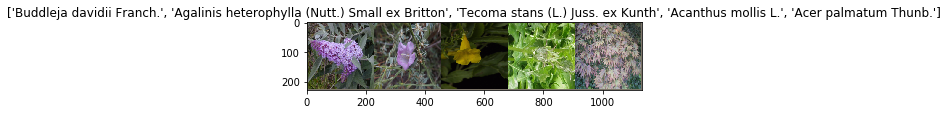

In [14]:
#Display sample batch images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

out = torchvision.utils.make_grid(images)
imshow(out, title = [classes[x.item()] for x in labels])

In [15]:
#Get sizes and loader as a single object
data_loaders={'train':train_loader,'val':val_loader}
dataset_sizes = {'train': len(train_idx), 'val':len(val_idx)}

In [16]:
#Method for saving checkpoints - useful for restarts
def save_checkpoint(state, is_best, filename='checkpoint.pth'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth')

In [17]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / (self.count*100)

In [19]:
def plotMetrics(epochs):   
    plt.plot(range(epochs), train_acc, color = 'r', label = 'training accuracy')
    plt.plot(range(epochs), top1_acc, color = 'g', label = 'top 1 validation accuracy')
    plt.plot(range(epochs), top5_acc, color = 'b', label = 'top 5 validation accuracy')
    plt.axis([0, epochs, 0, 1.1])
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.title('Comparison between training top 1 and top 5 accuracies')
    plt.legend(loc='lower right')
    plt.savefig("plantclef_true_1_trainVsvalAcc", dpi=300)
    plt.show()
    plt.gcf().clear()
    plt.plot(range(epochs), train_losses, color = 'y', label = 'training loss')
    plt.plot(range(epochs), val_losses, color = 'm', label = 'validation loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.title('Comparison between training and validation losses')
    plt.legend(loc='upper right')
    plt.savefig("plantclef_true_1_trainVsvalLoss", dpi=300)
    plt.show()
    plt.gcf().clear()

In [31]:
train_acc = []
top1_acc = []
top5_acc = []
train_losses = []
val_losses = []
best_acc = 0.0
best_prec1 = 0.0
best_prec5 = 0.0
time_elapsed = 0.0
top1 = AverageMeter()
top5 = AverageMeter()

#Function for training and validation
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    global best_acc
    global best_prec1
    global best_prec5
    global loss
    global time_elapsed
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            top1.reset()
            top5.reset()
            
            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = torch.from_numpy(np.asarray(labels)).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                # measure accuracy and record loss
                prec1, prec5 = accuracy(outputs, labels.data, topk=(1, 5))
                top1.update(prec1.item(), inputs.size(0))
                top5.update(prec5.item(), inputs.size(0))
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
              
            if phase == 'train':
                train_acc.append(top1.avg)
                train_losses.append(epoch_loss)
            elif phase == 'val':
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
                top1_acc.append(top1.avg)
                top5_acc.append(top5.avg)
            print('{} Loss: {:.4f} Top 1 Accuracy: {:.4f} Top 5 Accuracy: {:.4f}'.format(
                phase, epoch_loss, top1.avg, top5.avg))

            # deep copy the model
            is_best = top1.avg > best_prec1
    
            if phase == 'val':
                #Plot Metrics
                plotMetrics(epoch+1)
                if top1.avg > best_prec1:
                    best_prec1 = top1.avg
                    best_model_wts = copy.deepcopy(model.state_dict())
                if top5.avg > best_prec5:
                    best_prec5 = top5.avg
            save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
            'train_acc': train_acc,
            'top1_acc': top1_acc,
            'top5_acc': top5_acc,
            'train_losses': train_losses,
            'val_losses': val_losses
            }, is_best)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Top 1 Accuracy: {best_prec1:.4f}  Best Top 5 Accuracy: {best_prec5:.4f}'
              .format(best_prec1 = best_prec1, best_prec5 = best_prec5))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [32]:
#Visualizing few images with predictions and actuals
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = tuple(map(int, labels))
            labels = torch.from_numpy(np.asarray(labels)).to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} actual: {}'.format(classes[preds[j]], classes[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
#Save new weights and metafile after training and provide filenames
save_new_weights = True
save_meta_file = True
new_weights_filename = "plantclef_imagenet_true_1.pth" #Filename of the model to be saved
meta_filename = "plantclef_imagenet_true_1.txt"

#Hyperparameters
arch = "Resnet18" #Model Architecure
training_type = "PlantClef Imagenet True" #Type of training
loss_used = "Cross Entropy Loss" #Loss function used
optimizer_used = "SGD" #Optimizer used
lr = 0.001 #Learning Rate
momentum = 0.9 #Momentum
step_size = 7 #Step Size
gamma = 0.1 #Weight Decay
resume = '' #Path to latest checkpoint

In [34]:
#Finetuning the convnet from initial resnet_weights
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Let's use 2 GPUs!


In [35]:
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        train_acc = checkpoint['train_acc']
        top1_acc = checkpoint['top1_acc']
        top5_acc = checkpoint['top5_acc']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [36]:
#Training the model and storing its weights 
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 8.0673 Top 1 Accuracy: 0.0239 Top 5 Accuracy: 0.0639


Process Process-10:
Process Process-11:
Process Process-9:
Traceback (most recent call last):
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-8-8a1ae2e93ee3>", line 14, in __getitem__
    image = Image.open(img_name)
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/site-packages/PIL/Image.py", line 2477, in open
    fp = builtins.open(filename, "rb")
KeyboardInterrup

RuntimeError: DataLoader worker (pid 7182) exited unexpectedly with exit code 1.

KeyboardInterrupt
KeyboardInterrupt
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/vamsi.muthireddy/miniconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


In [21]:
#Saving the model
if save_new_weights:
    torch.save(model.state_dict(), new_weights_filename)

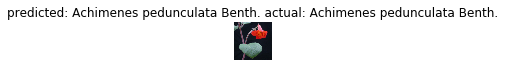

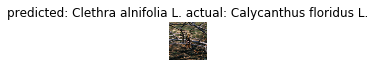

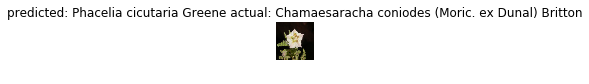

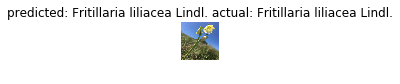

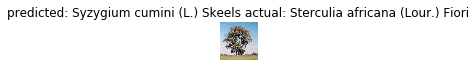

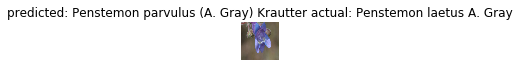

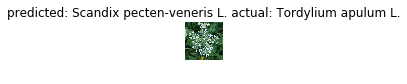

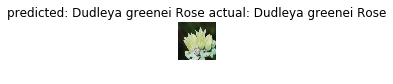

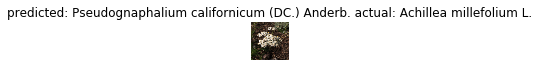

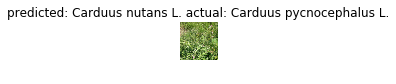

In [22]:
#Visualizing few predictions and actuals
visualize_model(model)

In [23]:
if(save_meta_file):
    f = open(meta_filename, "w+")
    f.write("Architecture: %s \n Training type: %s \n Loss used: %s \n Optimation used: %s \n Learning Rate: %2f \n Momentum: %2f \n Step Size: %d \n Gamma: %2f \n" %(arch, training_type, loss_used, optimizer_used, lr, momentum, step_size, gamma))
    f.write("\n \n \n Training Loss: \n \n \n")
    for loss in train_losses:
      f.write("%s, " % loss)
    f.write("\n \n \n Training Accuracy: \n \n \n")
    for acc in train_acc:
      f.write("%s, " % acc)
    f.write("\n \n \n Validation Loss: \n \n \n")
    for loss in val_losses:
      f.write("%s, " % loss)
    f.write("\n \n \n Top 1 Accuracy: \n \n \n")
    for acc in top1_acc:
      f.write("%s, " % acc)
    f.write("\n \n \n Top 5 Accuracy: \n \n \n")
    for acc in top5_acc:
      f.write("%s, " % acc)
    f.write('\n \n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    f.write('\n \n Best Top 1 Accuracy: {:4f}'.format(best_prec1))
    f.write('\n \n Best Top 5 Accuracy: {:4f}'.format(best_prec5))
    f.close()